# Analysis by using a second video

In [32]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import pandas as pd

In [33]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov2"
_recording_folder_name = "3marker_complete_data"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "recordings_160fov2", _calib_folder_name
)
_webcam_calib_folder = r'E:\CMC\pyprojects\programs_rpi\rpi_python\data\recordings_160fov\3marker_complete_data\3marker_april_mono_160fov_3'

_reference_recording_folder = os.path.join(
    _pth, '..', _parent_folder, _recording_folder_name, 'recordings_160fov2',
)
# _reference_file = os.path.join(_reference_recording_folder, "webcam_color.msgpack")
_reference_file = os.path.join(r'E:\CMC\pyprojects\programs_rpi\rpi_python\data\recordings4\randomxyz_t0', "webcam_color.msgpack")

# for loading 9000 values
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data.msgpack')

# for loading just 100 points
# _calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data_100values.msgpack')


In [34]:
_ref_video_length = 0

for _ in mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode):
    _ref_video_length += 1

print('video length, ', _ref_video_length)

video length,  2861


In [35]:
_ar_timestamp_file = os.path.join(
    r"E:\CMC\pyprojects\programs_rpi\rpi_python\data\recordings3\linearxz_t0", 'webcam_timestamp.msgpack')
_ar_timestamp = list(mp.Unpacker(open(_ar_timestamp_file, "rb"), object_hook=mpn.decode))
# _ar_timestamp = np.array(_ar_timestamp)

In [36]:
_sync = np.array(_ar_timestamp).T[0]
_timestamps = np.array(_ar_timestamp).T[1]

In [37]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients = np.zeros((5, 1))
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs, tvecs = [], []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            flags=cv2.SOLVEPNP_ITERATIVE,
        )
        if r is not None and t is not None:
            rvecs.append(r.reshape(1, 3).tolist())
            tvecs.append(t.reshape(1, 3).tolist())
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

## load clalibration data

In [38]:
_calib_data = list(mp.Unpacker(open(_calibration_data, "rb"), object_hook=mpn.decode))

In [39]:
import toml
_calib_data = toml.load(r'E:\CMC\pyprojects\programs_rpi\rpi_python\optimized_fisheye_calibration.toml')

matrix = np.array(_calib_data['calibration']['camera_matrix'], dtype=np.float32).reshape(3, 3)
distortion = np.array(_calib_data['calibration']['dist_coeffs'], dtype=np.float32)

In [40]:
# _calib_data

_new_matrix = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
    matrix, distortion, (1200, 800), np.eye(3))
_new_matrix

array([[470.6927 ,   0.     , 752.7785 ],
       [  0.     , 474.29047, 305.30548],
       [  0.     ,   0.     ,   1.     ]], dtype=float32)

In [41]:
def undistort_aruco_corners_fisheye(corners, camera_matrix, dist_coeffs):
    """
    Undistort ArUco corners using fisheye camera model.
    
    Args:
        corners: List of corner arrays from ArUco detection
        camera_matrix: Original fisheye camera matrix
        dist_coeffs: Fisheye distortion coefficients
    
    Returns:
        undistorted_corners: List of undistorted corner arrays
    """
    if corners is None or len(corners) == 0:
        return corners
    
    undistorted_corners = []
    
    for corner_set in corners:
        # Reshape corners to the format expected by undistortPoints
        corner_points = corner_set.reshape(-1, 1, 2).astype(np.float32)
        
        # Undistort using fisheye model
        undistorted_points = cv2.fisheye.undistortPoints(
            corner_points,
            camera_matrix,
            dist_coeffs,
            P=camera_matrix
        )
        
        # Reshape back to original format
        undistorted_corner_set = undistorted_points.reshape(corner_set.shape)
        undistorted_corners.append(undistorted_corner_set)
    
    return undistorted_corners

In [42]:
# selecting random 50 frames
np.random.seed(9)
_random_reference_frames_idx = np.random.choice(_ref_video_length, 300)

_ref_data = mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode)
_timestamp_data = mp.Unpacker(open(r'E:\CMC\pyprojects\programs_rpi\rpi_python\data\recordings4\randomxyz_t0\webcam_timestamp.msgpack', "rb"), object_hook=mpn.decode)

# _ref_frames = []

ar_total_results = {'calib_idx':[], 'ar_data':[]}
ar_results = {'corners': [], 'ids': [], 'rejected': [], 'rvecs': [], 'tvecs': []}
vector_std = {'v1std':[], 'v2std':[], 'v3std':[], 'sum':[]}

_timestamp = list(_timestamp_data)

for idx, _frame in tqdm(enumerate(_ref_data)):
    # _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    _frame = cv2.flip(_frame, 1)
    res = detector.detectMarkers(_frame,)
    
    res = detector.refineDetectedMarkers(_frame, board, res[0], res[1], res[2])
    
    corners = undistort_aruco_corners_fisheye(res[0], matrix, distortion)
    
    # res[0] = cv2.undistortPoints(
    #     res[0], matrix, distortion, P=_new_matrix)
    
    ar_results['corners'].append(corners)
    ar_results['ids'].append(res[1].T.reshape(-1))
    ar_results['rejected'].append(res[2])
    
    if res[0] is not None and len(res[0]) > 0:
        rvecs, tvecs = estimate_pose_single_markers(
            corners, markerLength, matrix, distortion
        )
        
        # rvecs, tvecs = estimate_pose_single_markers(
        #     res[0], markerLength, _new_matrix, np.zeros((5, 1))
        # )
        
        ar_results['rvecs'].append(rvecs)
        ar_results['tvecs'].append(tvecs)
    
    # if idx in _random_reference_frames_idx:
    #     _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    #     _ref_frames.append(_frame)


0it [00:00, ?it/s]

In [43]:
ar_results['ids'][0]

array([12, 20, 14], dtype=int32)

In [44]:
import numpy as np
import cv2

# Initialize the dictionary to store transformed translation vectors
transformed_tvec = {'12': [], '14': [], '20': []}
target_ids = [12, 14, 20]  # IDs we're interested in

for _id in range(len(ar_results['ids'])):
    sorted_ids = np.sort(ar_results['ids'][_id])
    sorted_id_index = np.argsort(ar_results['ids'][_id])
    _corners = np.array(ar_results['corners'][_id])[sorted_id_index]
    _rvecs = ar_results['rvecs'][_id][sorted_id_index]
    _tvecs = ar_results['tvecs'][_id][sorted_id_index]
   
    if _id == 0:
        # Store initial reference frame (assuming first detected marker)
        initial_rmat = cv2.Rodrigues(_rvecs[0])[0]
        initial_tvec = _tvecs[0]
    else:
        # Transform all detected markers to reference frame
        _temp_vec = _tvecs.reshape(-1, 3).T - initial_tvec.reshape(-1, 3).T
        _temp = (initial_rmat.T @ _temp_vec).T
        
        # Create a mapping from detected IDs to their transformed positions
        id_to_position = {}
        for i, marker_id in enumerate(sorted_ids):
            id_to_position[marker_id] = _temp[i]
        
        # For each target ID, append the transformed position or NaN if not detected
        for target_id in target_ids:
            if target_id in id_to_position:
                transformed_tvec[str(target_id)].append(id_to_position[target_id])
            else:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))

# Alternative approach using a more flexible data structure
def process_aruco_detections(ar_results, target_ids=[12, 14, 20]):
    """
    Process ArUco detection results, handling missing IDs gracefully.
    
    Args:
        ar_results: Dictionary containing 'ids', 'corners', 'rvecs', 'tvecs'
        target_ids: List of marker IDs we want to track
    
    Returns:
        Dictionary with transformed translation vectors for each target ID
    """
    transformed_tvec = {str(tid): [] for tid in target_ids}
    initial_rmat = None
    initial_tvec = None
    
    for frame_idx in range(len(ar_results['ids'])):
        if ar_results['ids'][frame_idx] is None or len(ar_results['ids'][frame_idx]) == 0:
            # No markers detected in this frame
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
            
        # Sort detections by ID for consistency
        sorted_indices = np.argsort(ar_results['ids'][frame_idx])
        sorted_ids = ar_results['ids'][frame_idx][sorted_indices]
        sorted_rvecs = ar_results['rvecs'][frame_idx][sorted_indices]
        sorted_tvecs = ar_results['tvecs'][frame_idx][sorted_indices]
        
        # Initialize reference frame from first detection
        if initial_rmat is None:
            initial_rmat = cv2.Rodrigues(sorted_rvecs[0])[0]
            initial_tvec = sorted_tvecs[0]
            # For the first frame, just fill with NaN (or zeros if preferred)
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
        
        # Transform all detected markers to reference frame
        temp_vec = sorted_tvecs.reshape(-1, 3).T - initial_tvec.reshape(-1, 3).T
        transformed_positions = (initial_rmat.T @ temp_vec).T
        
        # Create mapping from ID to transformed position
        id_to_position = dict(zip(sorted_ids, transformed_positions))
        
        # Append results for each target ID
        for target_id in target_ids:
            if target_id in id_to_position:
                transformed_tvec[str(target_id)].append(id_to_position[target_id])
            else:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
    
    return transformed_tvec

# Usage example:
# transformed_tvec = process_aruco_detections(ar_results, target_ids=[12, 14, 20])

# For handling NaN values later in your analysis:
def clean_transformed_data(transformed_tvec):
    """Remove NaN entries and return valid data points with their indices."""
    cleaned_data = {}
    for marker_id, positions in transformed_tvec.items():
        positions_array = np.array(positions)
        # Find rows where all values are not NaN
        valid_mask = ~np.isnan(positions_array).all(axis=1)
        cleaned_data[marker_id] = {
            'positions': positions_array[valid_mask],
            'frame_indices': np.where(valid_mask)[0]
        }
    return cleaned_data

In [45]:
transformed_tvec = process_aruco_detections(ar_results, target_ids=[12, 14, 20])
transformed_tvec = clean_transformed_data(transformed_tvec)

In [46]:
len(_timestamps), len(transformed_tvec['12']['positions']), 

(4383, 2860)

In [47]:
_time_df = pd.DataFrame({
    'time': _timestamps[:len(transformed_tvec['12']['positions'])],
    '12_x': transformed_tvec['12']['positions'][:, 0],
    '12_y': transformed_tvec['12']['positions'][:, 1],
    '12_z': transformed_tvec['12']['positions'][:, 2],
    # '14_x': transformed_tvec['14']['positions'][:, 0],
    # '14_y': transformed_tvec['14']['positions'][:, 1],
    # '14_z': transformed_tvec['14']['positions'][:, 2],
    # '20_x': transformed_tvec['20']['positions'][:, 0],
    # '20_y': transformed_tvec['20']['positions'][:, 1],
    # '20_z': transformed_tvec['20']['positions'][:, 2],
})
    

In [48]:
# convert time column to datetime
_time_df['time'] = pd.to_datetime(_time_df['time'])

In [49]:
_time_df

,time,12_x,12_y,12_z
0,2025-08-01 12:48:22.046482,0.000098,0.000338,-0.001712
1,2025-08-01 12:48:22.058716,0.000098,0.000338,-0.001712
2,2025-08-01 12:48:22.065701,0.000098,0.000338,-0.001712
3,2025-08-01 12:48:22.080447,0.000098,0.000338,-0.001712
4,2025-08-01 12:48:22.094076,0.000098,0.000338,-0.001712
...,...,...,...,...
2855,2025-08-01 12:48:50.601828,0.053633,0.013282,0.053297
2856,2025-08-01 12:48:50.611124,0.053606,0.013477,0.053452
2857,2025-08-01 12:48:50.619094,0.053606,0.013477,0.053452
2858,2025-08-01 12:48:50.631226,0.053606,0.013477,0.053452


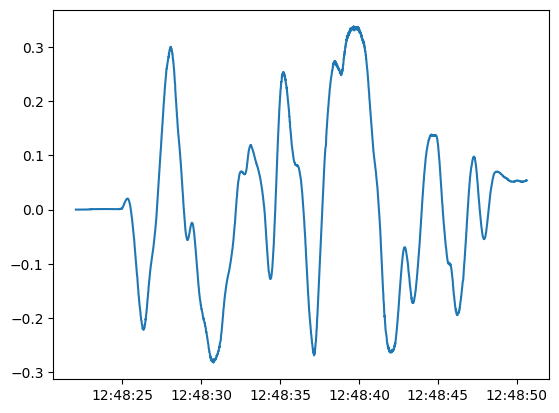

In [50]:
plt.plot(_time_df['time'],transformed_tvec['12']['positions'].T[0])


In [51]:
# transformed_tvec['12']['positions'].T

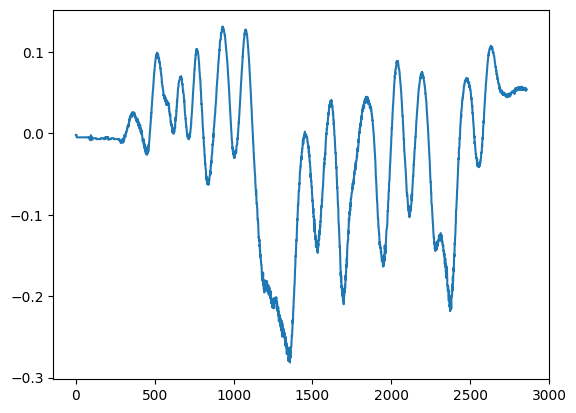

In [52]:
# plt.plot(transformed_tvec['12']['positions'].T[1])
plt.plot(transformed_tvec['12']['positions'].T[2])

In [53]:
# sadf

In [64]:
import sys
sys.path.insert(1, os.path.dirname(os.getcwd()))
from pd_support import *
_mocap_pth = r'E:\CMC\pyprojects\programs_rpi\rpi_python\data\recordings4\randomxyz_t0\randomxyz_t0.csv'
mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
mocap_df = add_datetime_col(mocap_df, st_time, 'seconds')

e:\CMC\pyprojects\programs_rpi\rpi_python\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [65]:
# mocap_df

In [66]:
rb_quat = mocap_df[['rb_ang_x', 'rb_ang_y', 'rb_ang_z', 'rb_ang_w']].values

rb_pos = mocap_df[['rb_pos_x', 'rb_pos_y', 'rb_pos_z']].values

In [67]:
from scipy.spatial.transform import Rotation as R
rb_matrix = R.from_quat(rb_quat[0]).as_matrix()

In [68]:
transformed_rb_pos = (rb_matrix.T @ (rb_pos.T - rb_pos[0].reshape(3,1))).T

In [69]:
# mocap_df['time']

[]

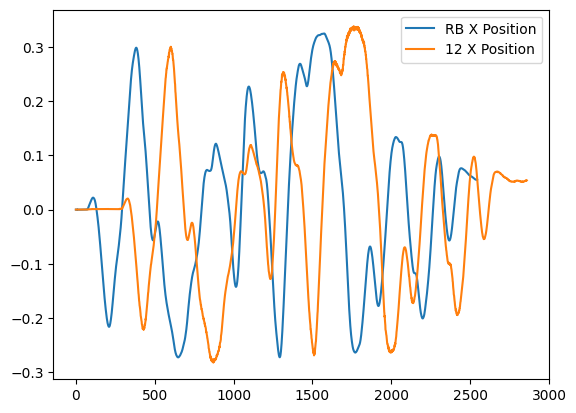

In [ ]:
plt.plot(mocap_df['time'], -1*transformed_rb_pos.T[0], label='RB /X Position')
plt.plot(_time_df['time'] - timedelta(seconds=3.1), transformed_tvec['12']['positions'].T[0], label='12 X Position')


# plt.plot(-1*transformed_rb_pos.T[0], label='RB X Position')
# plt.plot( transformed_tvec['12']['positions'].T[0], label='12 X Position')
plt.legend()
plt.plot()

[]

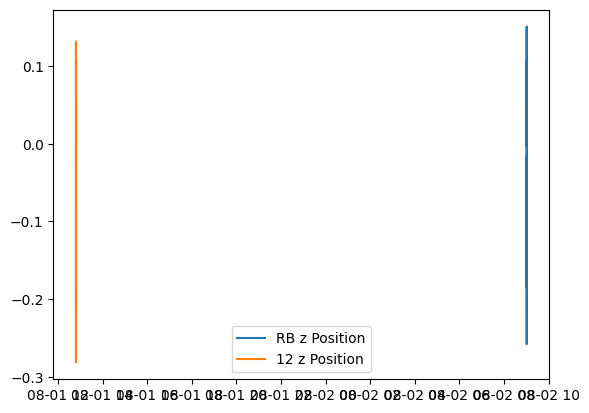

In [71]:
plt.plot(mocap_df['time'], transformed_rb_pos.T[1], label='RB z Position')
plt.plot(_time_df['time'] - timedelta(seconds=3.1), transformed_tvec['12']['positions'].T[2], label='12 z Position')
plt.legend()
plt.plot()

In [72]:
asfsdf

NameError: name 'asfsdf' is not defined

In [ ]:
import cv2
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import toml
from tqdm import tqdm

# Load fisheye calibration data
calib_data = toml.load(r'E:\CMC\pyprojects\programs_rpi\rpi_python\optimized_fisheye_calibration.toml')
matrix = np.array(calib_data['calibration']['camera_matrix'], dtype=np.float32).reshape(3, 3)
distortion = np.array(calib_data['calibration']['dist_coeffs'], dtype=np.float32)

def undistort_aruco_corners_fisheye(corners, camera_matrix, dist_coeffs):
    """
    Undistort ArUco corners using fisheye camera model.
    
    Args:
        corners: List of corner arrays from ArUco detection
        camera_matrix: Original fisheye camera matrix
        dist_coeffs: Fisheye distortion coefficients
    
    Returns:
        undistorted_corners: List of undistorted corner arrays
    """
    if corners is None or len(corners) == 0:
        return corners
    
    undistorted_corners = []
    
    for corner_set in corners:
        # Reshape corners to the format expected by undistortPoints
        corner_points = corner_set.reshape(-1, 1, 2).astype(np.float32)
        
        # Undistort using fisheye model
        undistorted_points = cv2.fisheye.undistortPoints(
            corner_points,
            camera_matrix,
            dist_coeffs,
            P=camera_matrix
        )
        
        # Reshape back to original format
        undistorted_corner_set = undistorted_points.reshape(corner_set.shape)
        undistorted_corners.append(undistorted_corner_set)
    
    return undistorted_corners

def process_aruco_detections_with_fisheye(ar_results, camera_matrix, dist_coeffs, marker_length, target_ids=[12, 14, 20]):
    """
    Process ArUco detection results with fisheye distortion correction, handling missing IDs gracefully.
    
    Args:
        ar_results: Dictionary containing 'ids', 'corners', 'rvecs', 'tvecs'
        camera_matrix: Fisheye camera matrix
        dist_coeffs: Fisheye distortion coefficients
        marker_length: Physical size of ArUco markers in meters
        target_ids: List of marker IDs we want to track
    
    Returns:
        Dictionary with transformed translation vectors for each target ID
    """
    transformed_tvec = {str(tid): [] for tid in target_ids}
    initial_rmat = None
    initial_tvec = None
    
    for frame_idx in range(len(ar_results['ids'])):
        if (ar_results['ids'][frame_idx] is None or 
            len(ar_results['ids'][frame_idx]) == 0 or
            ar_results['corners'][frame_idx] is None or
            len(ar_results['corners'][frame_idx]) == 0):
            # No markers detected in this frame
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
        
        # Get frame data
        frame_corners = ar_results['corners'][frame_idx]
        frame_ids = ar_results['ids'][frame_idx]
        
        # Undistort corners using fisheye model
        undistorted_corners = undistort_aruco_corners_fisheye(frame_corners, camera_matrix, dist_coeffs)
        
        # Estimate poses using undistorted corners
        if len(undistorted_corners) > 0:
            rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(
                undistorted_corners, 
                marker_length, 
                camera_matrix,
                np.zeros(4)  # No distortion after undistortion
            )
            
            # Convert to proper format
            rvecs = rvecs.reshape(-1, 3)
            tvecs = tvecs.reshape(-1, 3)
            
            # Sort detections by ID for consistency
            sorted_indices = np.argsort(frame_ids)
            sorted_ids = frame_ids[sorted_indices]
            sorted_rvecs = rvecs[sorted_indices]
            sorted_tvecs = tvecs[sorted_indices]
            
            # Initialize reference frame from first detection
            if initial_rmat is None:
                initial_rmat = cv2.Rodrigues(sorted_rvecs[0])[0]
                initial_tvec = sorted_tvecs[0]
                # For the first frame, fill with zeros or NaN
                for target_id in target_ids:
                    transformed_tvec[str(target_id)].append(np.zeros(3))
                continue
            
            # Transform all detected markers to reference frame
            temp_vec = sorted_tvecs.T - initial_tvec.reshape(-1, 1)
            transformed_positions = (initial_rmat.T @ temp_vec).T
            
            # Create mapping from ID to transformed position
            id_to_position = dict(zip(sorted_ids, transformed_positions))
            
            # Append results for each target ID
            for target_id in target_ids:
                if target_id in id_to_position:
                    transformed_tvec[str(target_id)].append(id_to_position[target_id])
                else:
                    transformed_tvec[str(target_id)].append(np.full(3, np.nan))
        else:
            # No valid poses estimated
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
    
    return transformed_tvec

def clean_transformed_data(transformed_tvec):
    """Remove NaN entries and return valid data points with their indices."""
    cleaned_data = {}
    for marker_id, positions in transformed_tvec.items():
        positions_array = np.array(positions)
        # Find rows where all values are not NaN
        valid_mask = ~np.isnan(positions_array).all(axis=1)
        cleaned_data[marker_id] = {
            'positions': positions_array[valid_mask],
            'frame_indices': np.where(valid_mask)[0]
        }
    return cleaned_data

# Main processing pipeline
def process_fisheye_aruco_pipeline(reference_file, timestamp_file, detector, board, markerLength, 
                                 camera_matrix, dist_coeffs, target_ids=[12, 14, 20], 
                                 num_frames=300, random_seed=9):
    """
    Complete pipeline for processing fisheye ArUco detection data.
    
    Args:
        reference_file: Path to msgpack file with video frames
        timestamp_file: Path to timestamp msgpack file
        detector: ArUco detector object
        board: ArUco board object
        markerLength: Physical size of markers in meters
        camera_matrix: Fisheye camera matrix
        dist_coeffs: Fisheye distortion coefficients
        target_ids: List of marker IDs to track
        num_frames: Number of frames to process
        random_seed: Random seed for frame selection
    
    Returns:
        Dictionary with processed results
    """
    # Load data
    np.random.seed(random_seed)
    ref_data = mp.Unpacker(open(reference_file, "rb"), object_hook=mpn.decode)
    timestamp_data = mp.Unpacker(open(timestamp_file, "rb"), object_hook=mpn.decode)
    
    # Initialize result containers
    ar_results = {
        'corners': [], 
        'ids': [], 
        'rejected': [], 
        'rvecs': [], 
        'tvecs': [],
        'undistorted_corners': []
    }
    
    timestamp = list(timestamp_data)
    
    for idx, frame in tqdm(enumerate(ref_data)):
        if idx >= num_frames:
            break
            
        frame = cv2.rotate(frame, cv2.ROTATE_180)
        
        # Detect markers
        res = detector.detectMarkers(frame)
        res = detector.refineDetectedMarkers(frame, board, res[0], res[1], res[2])
        
        # Store detection results
        ar_results['corners'].append(res[0])
        ar_results['ids'].append(res[1].T.reshape(-1) if res[1] is not None else None)
        ar_results['rejected'].append(res[2])
        
        if res[0] is not None and len(res[0]) > 0:
            # Undistort corners using fisheye model
            undistorted_corners = undistort_aruco_corners_fisheye(res[0], camera_matrix, dist_coeffs)
            ar_results['undistorted_corners'].append(undistorted_corners)
            
            # Estimate pose using undistorted corners
            rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(
                undistorted_corners, 
                markerLength, 
                camera_matrix,
                np.zeros(4)  # No distortion after undistortion
            )
            
            ar_results['rvecs'].append(rvecs)
            ar_results['tvecs'].append(tvecs)
        else:
            ar_results['undistorted_corners'].append(None)
            ar_results['rvecs'].append(None)
            ar_results['tvecs'].append(None)
    
    # Process the results to get transformed positions
    transformed_tvec = process_aruco_detections_with_fisheye(
        ar_results, camera_matrix, dist_coeffs, markerLength, target_ids
    )
    
    # Clean the data (remove NaN entries)
    cleaned_data = clean_transformed_data(transformed_tvec)
    
    return {
        'ar_results': ar_results,
        'transformed_tvec': transformed_tvec,
        'cleaned_data': cleaned_data,
        'timestamps': timestamp[:len(ar_results['corners'])]
    }


In [ ]:
import cv2
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import toml
from tqdm import tqdm

# STEP 1: Load calibration data and setup parameters
print("Step 1: Loading calibration data...")
calib_data = toml.load(r'E:\CMC\pyprojects\programs_rpi\rpi_python\optimized_fisheye_calibration.toml')
matrix = np.array(calib_data['calibration']['camera_matrix'], dtype=np.float32).reshape(3, 3)
distortion = np.array(calib_data['calibration']['dist_coeffs'], dtype=np.float32)

# Setup your other parameters
markerLength = 0.05  # 5cm markers (adjust as needed)
target_ids = [12, 14, 20]  # IDs you want to track
reference_file = _reference_file  # Update this path
timestamp_file = r'E:\CMC\pyprojects\programs_rpi\rpi_python\data\recordings_160fov\3marker_complete_data\3marker_april_mono_160fov_3\webcam_timestamp.msgpack'

# Initialize your detector and board (you should already have these)
# detector = cv2.aruco.ArucoDetector(...)
# board = cv2.aruco.CharucoBoard(...)

# STEP 2: Run the complete pipeline (this calls all other functions internally)
print("Step 2: Running complete fisheye ArUco pipeline...")
results = process_fisheye_aruco_pipeline(
    reference_file=reference_file,
    timestamp_file=timestamp_file,
    detector=detector,
    board=board,
    markerLength=markerLength,
    camera_matrix=matrix,
    dist_coeffs=distortion,
    target_ids=target_ids,
    num_frames=2000,
    random_seed=9
)

# STEP 3: Access your results
print("Step 3: Accessing results...")
transformed_positions = results['transformed_tvec']  # Main result you want
cleaned_positions = results['cleaned_data']         # Data with NaN removed
ar_detection_data = results['ar_results']           # Raw detection data
timestamps = results['timestamps']                  # Frame timestamps

print(f"Processed {len(ar_detection_data['corners'])} frames")
print(f"Target IDs: {list(transformed_positions.keys())}")

# STEP 4: Use your results
print("Step 4: Using the results...")
for marker_id in target_ids:
    positions = np.array(transformed_positions[str(marker_id)])
    valid_positions = positions[~np.isnan(positions).all(axis=1)]
    print(f"Marker {marker_id}: {len(valid_positions)} valid detections out of {len(positions)} frames")

# Optional: If you want more control, call functions individually instead of the pipeline
print("\n" + "="*50)
print("ALTERNATIVE: Individual function calls (if you need more control)")
print("="*50)

# Load your own data
ref_data = mp.Unpacker(open(reference_file, "rb"), object_hook=mpn.decode)
timestamp_data = mp.Unpacker(open(timestamp_file, "rb"), object_hook=mpn.decode)

ar_results = {'corners': [], 'ids': [], 'rejected': [], 'rvecs': [], 'tvecs': []}

# Process frames one by one
for idx, frame in enumerate(ref_data):
    if idx >= 300:  # Limit frames
        break
        
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    
    # Detect markers (your existing code)
    res = detector.detectMarkers(frame)
    res = detector.refineDetectedMarkers(frame, board, res[0], res[1], res[2])
    
    # Store results
    ar_results['corners'].append(res[0])
    ar_results['ids'].append(res[1].T.reshape(-1) if res[1] is not None else None)
    ar_results['rejected'].append(res[2])
    
    if res[0] is not None and len(res[0]) > 0:
        # Call undistort function
        undistorted_corners = undistort_aruco_corners_fisheye(res[0], matrix, distortion)
        
        # Estimate pose
        rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(
            undistorted_corners, markerLength, matrix, np.zeros(4)
        )
        
        ar_results['rvecs'].append(rvecs)
        ar_results['tvecs'].append(tvecs)
    else:
        ar_results['rvecs'].append(None)
        ar_results['tvecs'].append(None)

# Process the collected results
transformed_tvec = process_aruco_detections_with_fisheye(
    ar_results, matrix, distortion, markerLength, target_ids
)

# Clean the data
cleaned_data = clean_transformed_data(transformed_tvec)

print("Individual processing complete!")

Step 1: Loading calibration data...
Step 2: Running complete fisheye ArUco pipeline...


2000it [00:09, 216.46it/s]


Step 3: Accessing results...
Processed 2000 frames
Target IDs: ['12', '14', '20']
Step 4: Using the results...
Marker 12: 0 valid detections out of 2000 frames
Marker 14: 0 valid detections out of 2000 frames
Marker 20: 0 valid detections out of 2000 frames

ALTERNATIVE: Individual function calls (if you need more control)
Individual processing complete!


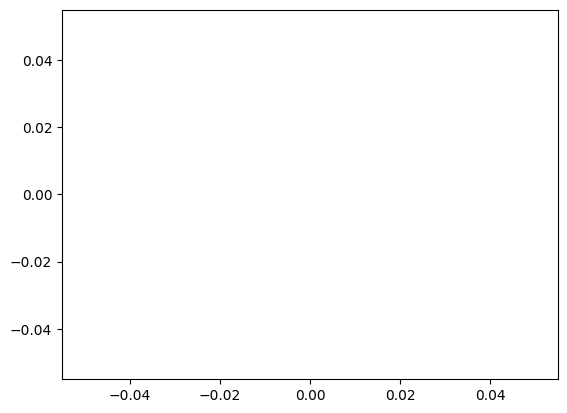

In [ ]:
plt.plot(cleaned_data['14']['positions'])

In [ ]:
_tvecs.reshape(-1, 3).T

array([[-0.03696549, -0.07789022,  0.00408531],
       [-0.05852973,  0.02368453,  0.02367458],
       [ 0.39828077,  0.40235463,  0.3878231 ]], dtype=float32)

In [ ]:
np.array(ar_results['corners'][0])[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
ar_results

{'corners': [], 'ids': [], 'rejected': [], 'rvecs': [], 'tvecs': []}

In [ ]:
initial_rmat

NameError: name 'initial_rmat' is not defined

In [ ]:
import numpy as np
from scipy import stats
from tqdm import tqdm
import cv2
from joblib import Parallel, delayed

# Define filtering functions outside the loop
def filter_90th_percentile_zscore(data, z_threshold=1.28):  # z=1.28 corresponds to ~90th percentile
    """Filter data to keep only values within 90th percentile using z-score"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    z_scores = np.abs(stats.zscore(data_clean))
    return data_clean[z_scores <= z_threshold]

def filter_90th_percentile_direct(data):
    """Filter data to keep only values up to 90th percentile"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    percentile_90 = np.percentile(data_clean, 90)
    return data_clean[data_clean <= percentile_90]

def process_single_calibration(idx, cal, ar_results):
    """Process a single calibration matrix"""
    mat = cal[0]
    dist = cal[1]
    
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        mat, dist, np.eye(3), mat, (1200, 800), cv2.CV_16SC2
    )
    new_matrix = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
        mat, dist, (1200, 800), None, None, cv2.CALIB_USE_INTRINSIC_GUESS
    )
    
    ordered_results = {'20': {'tvecs': [], 'rvecs': []},
                       '12': {'tvecs': [], 'rvecs': []},
                       '14': {'tvecs': [], 'rvecs': []}}
   
    vector_length = {'v1':[], 'v2':[], 'v3':[]}
    
    for res in zip(ar_results['ids'], ar_results['corners']):
        undistorted_corners = []
        for marker_corner in res[1]:
            undistorted_corners.append(cv2.undistortPoints(marker_corner.reshape(-1, 1, 2), mat, dist))
        undistorted_corners = np.array(undistorted_corners)
        pose = estimate_pose_single_markers(res[1], 0.05, mat, dist)
        v_12, v_14, v_20 = np.zeros((1,3)), np.zeros((1,3)), np.zeros((1,3))
        
        for idx_marker, id in enumerate(res[0].reshape(-1)):
            match id:
                case 20:
                    ordered_results['20']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['20']['rvecs'].append(pose[0][idx_marker])
                    v_20 = pose[1][idx_marker]
                case 12:
                    ordered_results['12']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['12']['rvecs'].append(pose[0][idx_marker])
                    v_12 = pose[1][idx_marker]
                case 14:
                    ordered_results['14']['tvecs'].append(pose[1][idx_marker])
                    ordered_results['14']['rvecs'].append(pose[0][idx_marker])
                    v_14 = pose[1][idx_marker]
                case _:
                    continue
       
        # Calculate vector lengths
        vector_length['v1'].append(np.linalg.norm(v_12 - v_14))
        vector_length['v2'].append(np.linalg.norm(v_14 - v_20))
        vector_length['v3'].append(np.linalg.norm(v_20 - v_12))
   
    # Apply filtering to each vector length array
    v1_filtered = filter_90th_percentile_direct(vector_length['v1'])
    v2_filtered = filter_90th_percentile_direct(vector_length['v2'])
    v3_filtered = filter_90th_percentile_direct(vector_length['v3'])
    
    # Calculate standard deviation on filtered data
    v1_std_val = np.nanstd(v1_filtered) if len(v1_filtered) > 0 else np.nan
    v2_std_val = np.nanstd(v2_filtered) if len(v2_filtered) > 0 else np.nan
    v3_std_val = np.nanstd(v3_filtered) if len(v3_filtered) > 0 else np.nan
    
    # Sum of standard deviations
    v1_std_final = v1_std_val if not np.isnan(v1_std_val) else 0
    v2_std_final = v2_std_val if not np.isnan(v2_std_val) else 0
    v3_std_final = v3_std_val if not np.isnan(v3_std_val) else 0
    sum_std = v1_std_final + v2_std_final + v3_std_final
    
    return {
        'calib_idx': idx,
        'ar_data': ordered_results,
        'v1std': v1_std_val,
        'v2std': v2_std_val,
        'v3std': v3_std_val,
        'sum': sum_std
    }

# Parallel processing of calibration matrices
print("Processing calibration matrices in parallel...")
calibration_data = list(zip(_calib_data[0]['mat'], _calib_data[0]['dist']))

# Use joblib to parallelize calibration processing
# n_jobs=-1 uses all available cores, you can set specific number like n_jobs=4
results = Parallel(n_jobs=20, verbose=1)(
    delayed(process_single_calibration)(idx, cal, ar_results) 
    for idx, cal in enumerate(tqdm(calibration_data, desc="Preparing calibration jobs"))
)

# Collect results
for result in results:
    ar_total_results['calib_idx'].append(result['calib_idx'])
    ar_total_results['ar_data'].append(result['ar_data'])
    vector_std['v1std'].append(result['v1std'])
    vector_std['v2std'].append(result['v2std'])
    vector_std['v3std'].append(result['v3std'])
    vector_std['sum'].append(result['sum'])

Processing calibration matrices in parallel...


Preparing calibration jobs: 100%|██████████| 9000/9000 [14:45<00:00, 10.16it/s]
[Parallel(n_jobs=20)]: Done 9000 out of 9000 | elapsed: 14.8min finished


In [ ]:
_optimization_file = os.path.join(_webcam_calib_folder, "optimization_file.msgpack")

with open(_optimization_file, "wb") as f:
    _packed_file = mp.packb([ar_total_results, vector_std], default=mpn.encode)
    f.write(_packed_file)

In [ ]:
np.argmin(vector_std['sum']), vector_std['sum'][np.argmin(vector_std['sum'])]

(np.int64(1881), np.float64(0.017823322048508363))

In [ ]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined